In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib widget
import seaborn as sns
sns.set()  # set plot styles
import sys
import os
from pathlib import Path
from scipy.signal import convolve
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d
# from scipy.stats import zscore ### Cave! scipy zscore does not handle NaN!
from ScanImageTiffReader import ScanImageTiffReader
from helpers import parse_SI_header as pSI #own
from tqdm import notebook

import rastermap as rm
import pandas as pd
import pickle

from sklearn.decomposition import NMF

### on-the-fly panda function definition of zscore that handles NaNs

In [3]:
def z_score(df): return (df-df.mean())/df.std(ddof=0)
# def m_mean(df): return df.mean()

# Batch processing

### User-specific folders

In [4]:
if sys.platform == "darwin":
    ### Mac
    main_root = '/Volumes/archive_bonhoeffer_group$/David Laubender/Data/imaging data/DL_191024_6/ImagingData/' #location of original data
    adata     = '/Volumes/archive_bonhoeffer_group$/David Laubender/adata' #location of saved analyzed data
    ftemp     = '/Users/trose/Data/temp' #fast disk (local ssd for s2p binary files) 
    ftiff     = '/Users/trose/Data/s2p_tiff' #fast disk folder for concatenated tiffs (if needed)
    xlpath    = '/Users/trose/Data/temp/LGNexperiments.xlsx' 
elif sys.platform == "win32":
#     main_root = 'I:/David Laubender/Data/imaging data/DL_191106_2/ImagingData' #location of original data
    main_root = 'I:/David Laubender/Data/imaging data/DL_191024_6/ImagingData' #location of original data    
    adata     = 'I:/David Laubender/adata' #location of saved analyzed data
    ftemp     = 'C:/temp/trose/suite2ptemp' #fast disk (local ssd for s2p binary files  
    ftiff     = 'C:/temp/trose/s2p_tiff' #fast disk folder for concatenated tiffs (if needed)
    xlpath    = 'C:\\temp\data\LGNexperiments.xlsx' 

### read excel file into panda dataframe

In [5]:
df = pd.read_excel(xlpath, index_col=0)

### split comments column into Layer and elevation columns and drop mixed column

In [6]:
df[['Layer', 'Elevation']] = df.comments.str.rsplit(',', expand = True)
df = df.drop(['comments'], axis=1)

###  boolean combination of search strings (here: Euler stim only)

In [7]:
# df[(df['experiment type'] == 'euler' ) & (df['Layer'] == 'L1')]
# load_df = df[(df['experiment type'] == 'euler' ) & (df['Layer'] == 'L1') & (df['Elevation']==' positive degrees')]
#load_df = df[(df['experiment type'] == 'euler' ) & (df['Layer'] == 'L4')]
load_df = df[(df['experiment type'] == 'euler' )]
exp=list(map(str,load_df.experiment))
main_root=list(map(str,load_df.folder))
# list(main_root)
# list(exp)

# load panda dataframe, Stim-IDs and one aux from disk

In [41]:
dataframe = pd.read_pickle('layer1_and_4_mac_grat_small.pkl')

NotImplementedError: cannot instantiate 'WindowsPath' on your system

In [9]:
with open('Chirp_ids.pkl', 'rb') as handle:
    ids = pickle.load(handle)

In [10]:
auxdata = ids[0]['auxdata']


In [11]:
level = dataframe['SI_level'].to_numpy()[0]

In [125]:
len(dataframe)

2202120

# generate sorted mean-cell responses / zscores or not

In [ ]:
dataframe[dataframe['category'] == 'Ipsi'].groupby(['time', 'cell'], as_index=True).aligned_spks.head()

In [126]:
l = dataframe[(dataframe['category'] == 'Ipsi') & (dataframe['Stimulus_ID'] == 1)].aligned_spks.to_numpy()

In [127]:
l

array([array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 37.48140717,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 27.73633194,
        0.        ,  0.        ,  0.        , 26.29735184, 38.75056839,
        0.        ,  3.5790503 ,  0.        ,  0.        , 70.69895935,
        0.        ,  0.        ,  0.        , 37.15786362,  0.        ,
       18.82841492,  0.        , 36.07233047,  0.        ,  0.        ,
       24.51958847,  0.        ,  0.        ,  0.        ,  0.        ,
       55.11973953,  0.        ,  0.        ,         nan]),
       array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 16.05578041,  0.        ,  0.        ,
        0.        ,  0.        ,  4.37195635,  8.43313313,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0

In [80]:
# generate sorted mean-cell responses / zscores or not

allcells_Ipsi_mean = dataframe.loc[dataframe.loc[:,'category'] == 'Ipsi'].groupby(['time', 'cell'], as_index=False).aligned_spks.mean().pivot(index = 'time', columns='cell')
allcells_Ipsi_mean_zscored = allcells_Ipsi_mean.transform((lambda x : z_score(x)))
sortidx = allcells_Ipsi_mean_zscored.max().sort_values(ascending=False).index
allcells_Ipsi_mean_sort_zscored = allcells_Ipsi_mean_zscored.reindex(sortidx, axis = 1)
# probably cast that back into proper dataframe locations... too brainf*&%*% for this right now

allcells_Contra_mean = dataframe.loc[dataframe.loc[:,'category'] == 'Contra'].groupby(['time', 'cell'], as_index=False).aligned_spks.mean().pivot(index = 'time', columns='cell')
allcells_Contra_mean_zscored = allcells_Contra_mean.transform((lambda x : z_score(x)))
sortidx = allcells_Contra_mean_zscored.max().sort_values(ascending=False).index
allcells_Contra_mean_sort_zscored = allcells_Contra_mean_zscored.reindex(sortidx, axis = 1)

allcells_Bino_mean = dataframe.loc[dataframe.loc[:,'category'] == 'Bino'].groupby(['time', 'cell'], as_index=False).aligned_spks.mean().pivot(index = 'time', columns='cell')
allcells_Bino_mean_zscored = allcells_Bino_mean.transform((lambda x : z_score(x)))
sortidx = allcells_Bino_mean_zscored.max().sort_values(ascending=False).index
allcells_Bino_mean_sort_zscored = allcells_Bino_mean_zscored.reindex(sortidx, axis = 1)


allcells_Ipsi_mean = dataframe.loc[dataframe.loc[:,'category'] == 'Ipsi'].groupby(['time', 'cell'], as_index=False).aligned_spks.mean().pivot(index = 'time', columns='cell')
sortidx2 = allcells_Ipsi_mean.max().sort_values(ascending=False).index
allcells_Ipsi_mean_sort = allcells_Ipsi_mean.reindex(sortidx2, axis = 1)

allcells_Contra_mean = dataframe.loc[dataframe.loc[:,'category'] == 'Contra'].groupby(['time', 'cell'], as_index=False).aligned_spks.mean().pivot(index = 'time', columns='cell')
sortidx2 = allcells_Contra_mean.max().sort_values(ascending=False).index
allcells_Contra_mean_sort = allcells_Contra_mean.reindex(sortidx2, axis = 1)

allcells_Bino_mean = dataframe.loc[dataframe.loc[:,'category'] == 'Bino'].groupby(['time', 'cell'], as_index=False).aligned_spks.mean().pivot(index = 'time', columns='cell')
sortidx2 = allcells_Bino_mean.max().sort_values(ascending=False).index
allcells_Bino_mean_sort = allcells_Bino_mean.reindex(sortidx2, axis = 1)


# allcells_Ipsi_mean = dataframe.loc[dataframe.loc[:,'category'] == 'Ipsi'].groupby(['time', 'cell'], as_index=False).aligned_F.mean().pivot(index = 'time', columns='cell')
# allcells_Ipsi_mean_zscored = allcells_Ipsi_mean.transform((lambda x : z_score(x)))
# sortidx = allcells_Ipsi_mean_zscored.max().sort_values(ascending=False).index
# allcells_Ipsi_mean_sort_zscored = allcells_Ipsi_mean_zscored.reindex(sortidx, axis = 1)

# allcells_Contra_mean = dataframe.loc[dataframe.loc[:,'category'] == 'Contra'].groupby(['time', 'cell'], as_index=False).aligned_F.mean().pivot(index = 'time', columns='cell')
# allcells_Contra_mean_zscored = allcells_Contra_mean.transform((lambda x : z_score(x)))
# sortidx = allcells_Contra_mean_zscored.max().sort_values(ascending=False).index
# allcells_Contra_mean_sort_zscored = allcells_Contra_mean_zscored.reindex(sortidx, axis = 1)

# allcells_Bino_mean = dataframe.loc[dataframe.loc[:,'category'] == 'Bino'].groupby(['time', 'cell'], as_index=False).aligned_F.mean().pivot(index = 'time', columns='cell')
# allcells_Bino_mean_zscored = allcells_Bino_mean.transform((lambda x : z_score(x)))
# sortidx = allcells_Bino_mean_zscored.max().sort_values(ascending=False).index
# allcells_Bino_mean_sort_zscored = allcells_Bino_mean_zscored.reindex(sortidx, axis = 1)


# allcells_Ipsi_mean = dataframe.loc[dataframe.loc[:,'category'] == 'Ipsi'].groupby(['time', 'cell'], as_index=False).aligned_F.mean().pivot(index = 'time', columns='cell')
# sortidx2 = allcells_Ipsi_mean.max().sort_values(ascending=False).index
# allcells_Ipsi_mean_sort = allcells_Ipsi_mean.reindex(sortidx2, axis = 1)

# allcells_Contra_mean = dataframe.loc[dataframe.loc[:,'category'] == 'Contra'].groupby(['time', 'cell'], as_index=False).aligned_F.mean().pivot(index = 'time', columns='cell')
# sortidx2 = allcells_Contra_mean.max().sort_values(ascending=False).index
# allcells_Contra_mean_sort = allcells_Contra_mean.reindex(sortidx2, axis = 1)

# allcells_Bino_mean = dataframe.loc[dataframe.loc[:,'category'] == 'Bino'].groupby(['time', 'cell'], as_index=False).aligned_F.mean().pivot(index = 'time', columns='cell')
# allcells_Bino_mean_zscored = allcells_Bino_mean.transform((lambda x : z_score(x)))
# sortidx2 = allcells_Bino_mean.max().sort_values(ascending=False).index
# allcells_Bino_mean_sort = allcells_Bino_mean.reindex(sortidx2, axis = 1)

DataError: No numeric types to aggregate

### Rastermap sorting

In [13]:
# all cells
sp_ipsi = allcells_Ipsi_mean_zscored.to_numpy()
sp_contra = allcells_Contra_mean_zscored.to_numpy()
sp_bino = allcells_Bino_mean_zscored.to_numpy()

sp_all = np.concatenate((allcells_Contra_mean.to_numpy(), allcells_Ipsi_mean.to_numpy(), allcells_Bino_mean.to_numpy()), axis = 0)

sp_ipsi[np.isnan(sp_ipsi)] = 0
sp_contra[np.isnan(sp_contra)] = 0
sp_bino[np.isnan(sp_bino)] = 0

sp_all[np.isnan(sp_all)] = 0

sp_all = zscore(sp_all) # needs to be done in numpy to be element-wise here - I collapsed the major categories. I dont think I can do that in pandas straight



In [14]:
%%capture
model_ipsi = rm.mapping.Rastermap(n_components=1).fit(sp_ipsi.T)
model_contra = rm.mapping.Rastermap(n_components=1).fit(sp_contra.T)
model_bino = rm.mapping.Rastermap(n_components=1).fit(sp_bino.T)
model_all = rm.mapping.Rastermap(n_components=1).fit(sp_all.T)

In [15]:
### sort neurons and smooth across neurons 
smooth = True
timesmooth = False

if smooth:
    isort = np.argsort(model_contra.embedding[:,0])   
    Sm_ipsi = gaussian_filter1d(sp_ipsi.T[isort,:], np.minimum(3,int(sp_ipsi.shape[0]*0.05)), axis=0)
    # isort = np.argsort(model_contra.embedding[:,0])
    Sm_contra = gaussian_filter1d(sp_contra.T[isort,:], np.minimum(3,int(sp_contra.shape[0]*0.05)), axis=0)
    # isort = np.argsort(model_bino.embedding[:,0])
    Sm_bino = gaussian_filter1d(sp_bino.T[isort,:], np.minimum(3,int(sp_bino.shape[0]*0.05)), axis=0)
    Sm_all  = gaussian_filter1d(sp_all.T[isort,:], np.minimum(3,int(sp_all.shape[0]*0.05)), axis=0)
#     Sm_all= sp_all.T[isort,:]
else:
    isort = np.argsort(model_contra.embedding[:,0])
    Sm_ipsi = sp_ipsi.T[isort,:]
    # isort = np.argsort(model_contra.embedding[:,0])
    Sm_contra = sp_contra.T[isort,:]
    # isort = np.argsort(model_bino.embedding[:,0])
    Sm_bino = sp_bino.T[isort,:]
    Sm_all  = sp_all.T[isort,:]

    
if timesmooth:
    sigma = 0.5
# (optional) smooth in time
    Sm_contra = gaussian_filter1d(Sm_contra, sigma, axis=1)
    Sm_ipsi = gaussian_filter1d(Sm_ipsi, sigma, axis=1)
    Sm_bino = gaussian_filter1d(Sm_bino, sigma, axis=1)
    Sm_all = gaussian_filter1d(Sm_all, sigma, axis=1)

# Stimulus parameters

In [16]:
categories = ['Ipsi', 'Contra', 'Bino'] #ids.keys()
ncells = {}
prestim = {}
poststim = {}
prestim_frames = {}
poststim_frames = {}

for idx, val in enumerate(exp):    
    prestim[idx]  = 1 / (ids[idx]['framerate_auxderived']  / level) * 5 #seconds before stimulus
    poststim[idx] = 1 / (ids[idx]['framerate_auxderived']  / level) * 5 #seconds after stimulus

    prestim_frames[idx] = np.round(prestim[idx]  * (ids[idx]['framerate_auxderived']  / level))
    poststim_frames[idx] = np.round(prestim[idx]  * (ids[idx]['framerate_auxderived']  / level))

### Euler stim parameters

In [17]:
euler_baseline = 5
flashdur = 3
ITI_black = 3
pre_chirp = 3
chirp = 8

### auxdata and timebase 

In [18]:
stimops = {
    'Frames_chan': 3,
    'Stims_chan': 7,
    'eye1_chan': 16,
    'eye2_chan': 17,
    'level': level, # extract from SI file in the future
    'minsample_delta': 100 
     }


In [19]:
cellglob = len(sp_ipsi.T)

In [20]:
maxlength = dataframe['time'][(dataframe['cell'] == 1) & (dataframe['trial'] == 1) &  (dataframe['category'] == 'Ipsi') ].shape[0]

In [21]:
time = dataframe['time'][(dataframe['cell'] == 1) & (dataframe['trial'] == 1) &  (dataframe['category'] == 'Ipsi')].to_numpy()

In [22]:
slice_range = np.arange(ids[0]['Ipsi'][0][1].astype(int)-prestim_frames[0].astype(int),ids[0]['Ipsi'][1][1].astype(int)+poststim_frames[0].astype(int)+1)
# slice_range = np.arange(ids[category][0][trial].astype(int)-prestim_frames.astype(int),ids[category][1][trial].astype(int)+poststim_frames.astype(int))

aligned_stimdata = auxdata[ids[0]['FrameTimes_level'][slice_range],stimops['Stims_chan']]
# aligned_stimdata_concat = np.tile(auxdata[ids['FrameTimes_level'][slice_range],stimops['Stims_chan']], (0,3))
aux_time = np.arange(0, aligned_stimdata.shape[0] * 1 / (ids[0]['framerate_auxderived'] / level), 1 / (ids[0]['framerate_auxderived'] / level) ) - prestim[0]

aligned_stimdata_full = ids[0]['auxdata'][ids[0]['FrameTimes_level'][slice_range[0]]:ids[0]['FrameTimes_level'][slice_range[-1]],stimops['Stims_chan']]
aligned_stimdata_full_concat = np.tile(aligned_stimdata_full, (1,3)).T

aux_time_full = np.arange(0, aligned_stimdata_full.shape[0] * 1 / ids[0]['aux_samplingfreq'] , 1 / ids[0]['aux_samplingfreq']    ) - prestim[0]
aux_time_full_concat = np.arange(0, aligned_stimdata_full_concat.shape[0] * 1 / ids[0]['aux_samplingfreq'] , 1 / ids[0]['aux_samplingfreq']   ) - prestim[0]

# plt.figure()
# plt.plot(aux_time, aligned_stimdata)
# plt.plot(aux_time_full_concat, aligned_stimdata_full_concat)

### seperately sorted

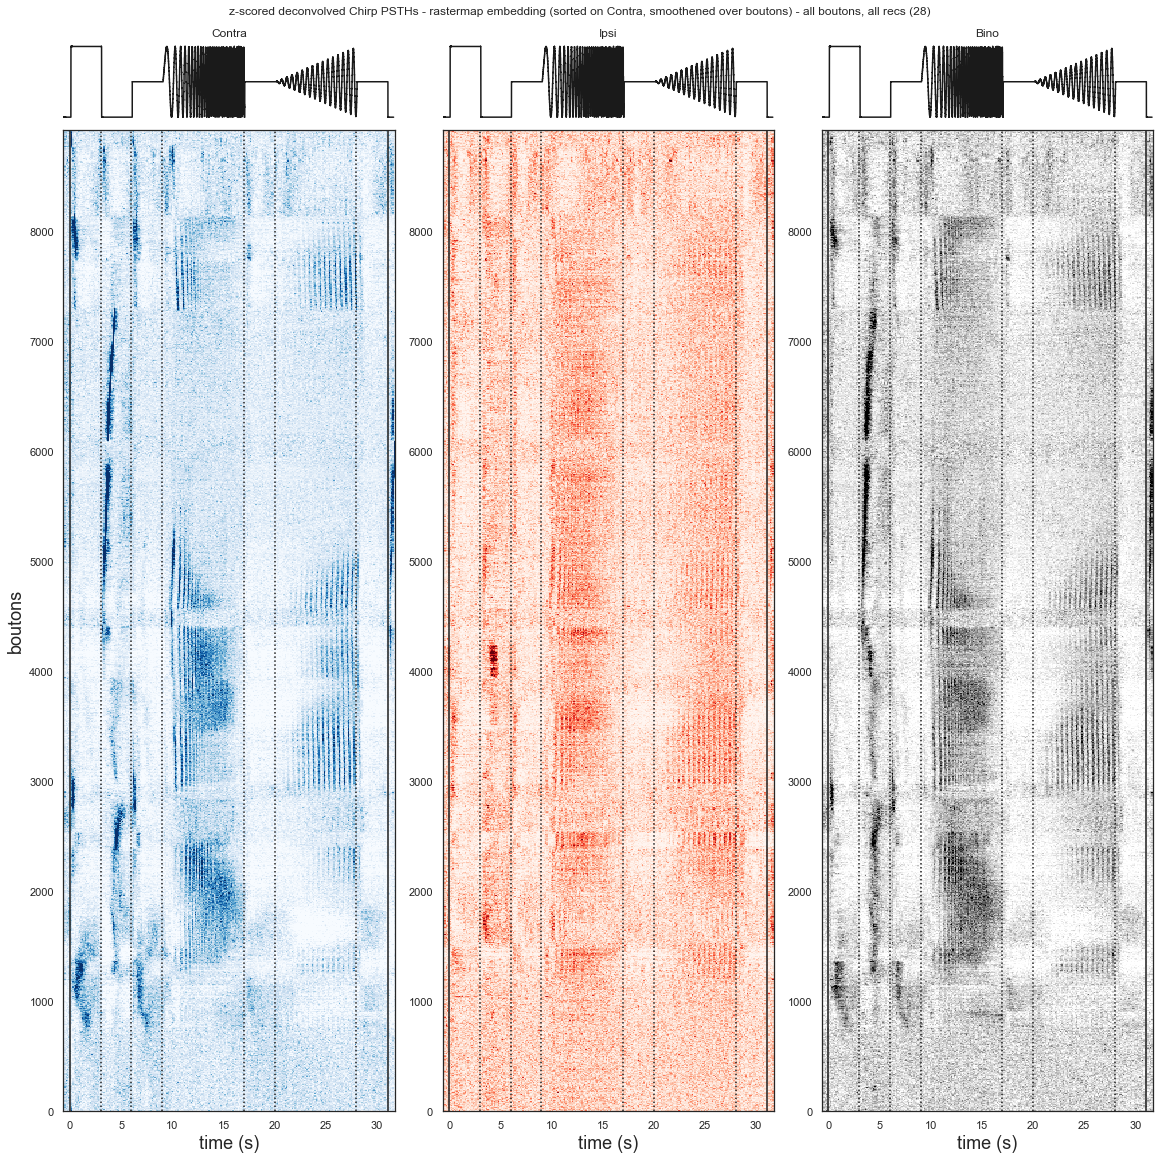

In [24]:
### view neuron sorting

# aligned_stimdata = auxdata[ids['FrameTimes_level'][slice_range][0]:ids['FrameTimes_level'][slice_range][-1],stimops['Stims_chan']]
# aux_time = np.arange(0, aligned_stimdata.shape[0] * 1 / aux_samplingfreq, 1 / aux_samplingfreq  ) - prestim

fs = ids[0]['framerate_auxderived'] / level
vmin_glob = -.5
vmax_glob = 2.5
ncells = cellglob 
with sns.axes_style('white'):
    xl = [-prestim[0],Sm_contra.shape[1]/fs-prestim[0]]

    fig8 = plt.figure(figsize=(16,16), constrained_layout=True)
    gs1 = fig8.add_gridspec(nrows=8, ncols=3)

    fig8.add_subplot(gs1[1:, :-2])      
    fig8_ax=plt.imshow(Sm_contra, vmin=vmin_glob,vmax=vmax_glob,aspect='auto',extent=[-prestim[0],Sm_contra.shape[1]/fs-prestim[0], 0,Sm_contra.shape[0]], cmap = 'Blues')
    plt.xlabel('time (s)', fontsize=18)    

    plt.vlines([prestim_frames[0] / fs-prestim[0], maxlength / fs - poststim_frames[0] / fs -prestim[0] ],0,ncells-1, 'k')
    plt.vlines([prestim_frames[0] / fs-prestim[0] + flashdur, 
                prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black, 
                prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp,
                prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp + chirp,
                prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp + chirp + ITI_black,
                prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp + chirp + ITI_black + chirp,
               ],0,ncells-1, 'k', 'dotted')

    plt.ylabel('boutons', fontsize=18)     

    f8_ax2 = fig8.add_subplot(gs1[1:, 1:-1])
    ax=plt.imshow(Sm_ipsi, vmin=vmin_glob,vmax=vmax_glob,aspect='auto',extent=[-prestim[0],Sm_ipsi.shape[1]/fs-prestim[0], 0,Sm_ipsi.shape[0]], cmap = 'Reds')
    plt.xlabel('time (s)', fontsize=18)

    plt.vlines([prestim_frames[0] / fs-prestim[0], maxlength / fs - poststim_frames[0] / fs -prestim[0] ],0,ncells-1, 'k')
    plt.vlines([prestim_frames[0] / fs-prestim[0] + flashdur, 
                prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black, 
                prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp,
                prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp + chirp,
                prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp + chirp + ITI_black,
                prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp + chirp + ITI_black + chirp,
               ],0,ncells-1, 'k', 'dotted')


    f8_ax3 = fig8.add_subplot(gs1[1:, 2:])
    ax=plt.imshow(Sm_bino, vmin=vmin_glob,vmax=vmax_glob,aspect='auto',extent=[-prestim[0],Sm_bino.shape[1]/fs-prestim[0], 0,Sm_bino.shape[0]], cmap = 'gray_r')
    plt.xlabel('time (s)', fontsize=18)

    plt.vlines([prestim_frames[0] / fs-prestim[0], maxlength / fs - poststim_frames[0] / fs -prestim[0]],0,ncells-1, 'k')
    plt.vlines([prestim_frames[0] / fs-prestim[0] + flashdur, 
                prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black, 
                prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp,
                prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp + chirp,
                prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp + chirp + ITI_black,
                prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp + chirp + ITI_black + chirp,
               ],0,ncells-1, 'k', 'dotted')

    #    plt.colorbar(label='deconvolved F [a.u.]')

    f8_ax4 = fig8.add_subplot(gs1[:1, :-2])    
    plt.plot(aux_time_full, aligned_stimdata_full, 'k')
    #     plt.vlines([prestim_frames / fs-prestim, maxlength / fs - poststim_frames / fs -prestim],0,4, 'k')
    f8_ax4.set_xlim(*xl)
    f8_ax4.axis('off')
    plt.title('Contra')

    f8_ax5 = fig8.add_subplot(gs1[:1, 1:-1])
    plt.plot(aux_time_full, aligned_stimdata_full, 'k')
    f8_ax5.set_xlim(*xl)
    f8_ax5.axis('off')
    plt.title('Ipsi')


    f8_ax6 = fig8.add_subplot(gs1[:1, 2:])
    plt.plot(aux_time_full, aligned_stimdata_full, 'k')
    f8_ax6.set_xlim(*xl)
    f8_ax6.axis('off')
    plt.title('Bino')    

    #     plt.tight_layout()           
    plt.suptitle('z-scored deconvolved Chirp PSTHs - rastermap embedding (sorted on Contra, smoothened over boutons) - all boutons, all recs (28)')

plt.show()

In [25]:
plt.savefig('separate_contrasort.pdf', format='pdf')

<Figure size 432x288 with 0 Axes>

### concatenated figure

In [35]:
### sort neurons and smooth across neurons 
smooth = True
timesmooth = True

if smooth:
    isort = np.argsort(model_all.embedding[:,0])   
    Sm_ipsi = gaussian_filter1d(sp_ipsi.T[isort,:], np.minimum(3,int(sp_ipsi.shape[0]*0.05)), axis=0)
    # isort = np.argsort(model_contra.embedding[:,0])
    Sm_contra = gaussian_filter1d(sp_contra.T[isort,:], np.minimum(3,int(sp_contra.shape[0]*0.05)), axis=0)
    # isort = np.argsort(model_bino.embedding[:,0])
    Sm_bino = gaussian_filter1d(sp_bino.T[isort,:], np.minimum(3,int(sp_bino.shape[0]*0.05)), axis=0)
    Sm_all  = gaussian_filter1d(sp_all.T[isort,:], np.minimum(3,int(sp_all.shape[0]*0.05)), axis=0)
#     Sm_all= sp_all.T[isort,:]
else:
    isort = np.argsort(model_all.embedding[:,0])
    Sm_ipsi = sp_ipsi.T[isort,:]
    # isort = np.argsort(model_contra.embedding[:,0])
    Sm_contra = sp_contra.T[isort,:]
    # isort = np.argsort(model_bino.embedding[:,0])
    Sm_bino = sp_bino.T[isort,:]
    Sm_all  = sp_all.T[isort,:]

    
if timesmooth:
    sigma = 0.5
# (optional) smooth in time
    Sm_contra = gaussian_filter1d(Sm_contra, sigma, axis=1)
    Sm_ipsi = gaussian_filter1d(Sm_ipsi, sigma, axis=1)
    Sm_bino = gaussian_filter1d(Sm_bino, sigma, axis=1)
    Sm_all = gaussian_filter1d(Sm_all, sigma, axis=1)

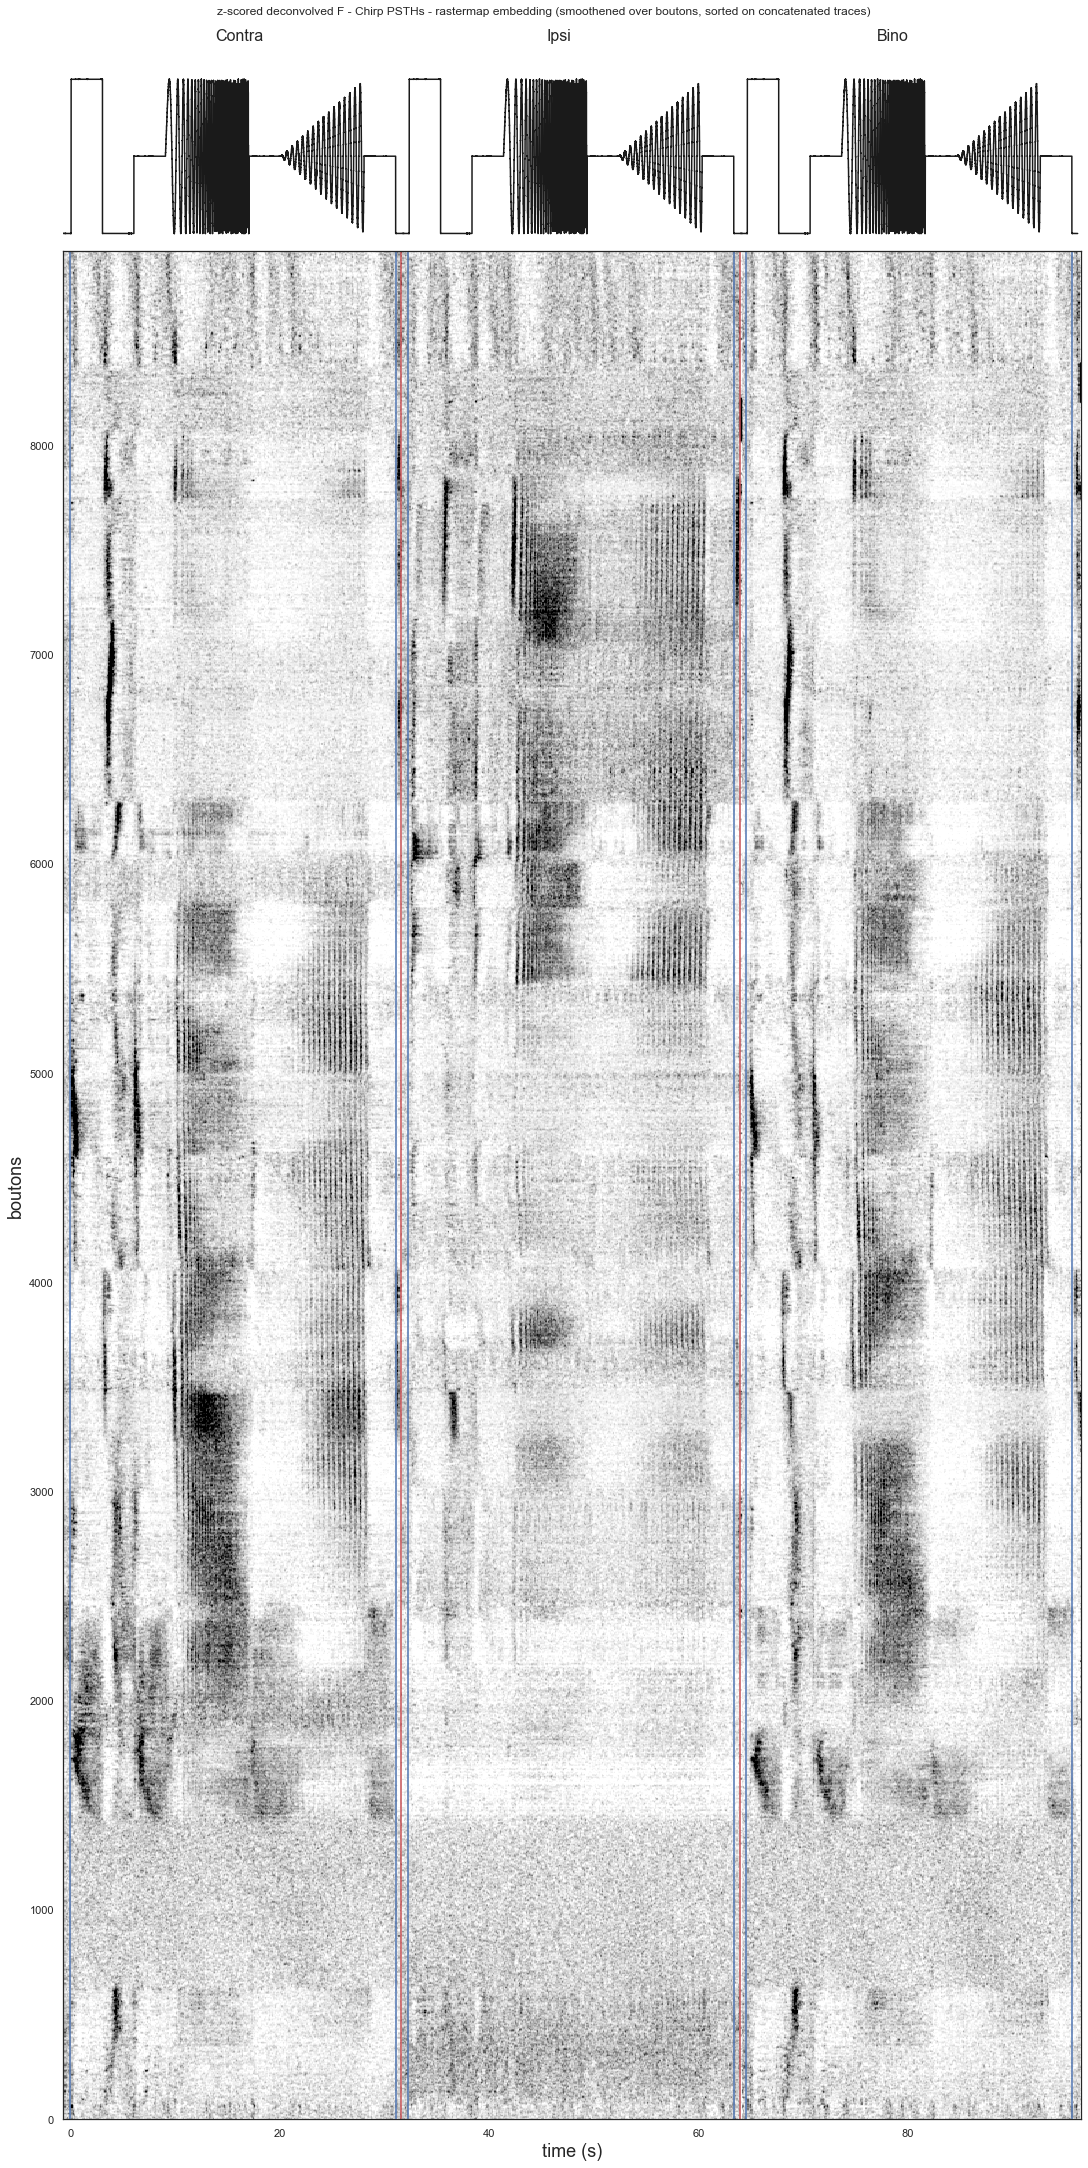

In [36]:
### view neuron sorting

# aligned_stimdata = auxdata[ids['FrameTimes_level'][slice_range][0]:ids['FrameTimes_level'][slice_range][-1],stimops['Stims_chan']]
# aux_time = np.arange(0, aligned_stimdata.shape[0] * 1 / aux_samplingfreq, 1 / aux_samplingfreq  ) - prestim

fs = ids[0]['framerate_auxderived'] / level
vmin_glob = -.5
vmax_glob = 2.5


with sns.axes_style('white'):
    xl = [-prestim[0],Sm_all.shape[1]/fs - prestim[0]]
    
    fig9 = plt.figure(figsize=(15,30), constrained_layout=True)
    
    gs1 = fig9.add_gridspec(nrows=12, ncols=3)
    
    fig9.add_subplot(gs1[1:, :])      
    fig9_ax=plt.imshow(Sm_all, vmin=vmin_glob,vmax=vmax_glob,aspect='auto',extent=[-prestim[0],Sm_all.shape[1]/fs-prestim[0], 0,Sm_all.shape[0]], cmap = 'gray_r')
    plt.xlabel('time (s)', fontsize=18)    
    
#     plt.vlines([prestim_frames / fs-prestim, maxlength / fs - poststim_frames / fs -prestim ],0,ncells-1, 'k')
    plt.ylabel('boutons', fontsize=18)     
    
    plt.vlines([aux_time_full[-1],  +aux_time_full[-1] *2 + poststim[0]],0,ncells-1, 'r')
    plt.vlines([prestim_frames[0] / fs-prestim[0], maxlength / fs - poststim_frames[0] / fs -prestim[0]],0,ncells-1, 'b')
    
    plt.vlines([aux_time_full[-1] + (prestim_frames[0] / fs),  aux_time_full[-1] + (maxlength / fs - poststim_frames[0] / fs ) ],0,ncells-1, 'b')
    plt.vlines([2 * aux_time_full[-1] + (prestim_frames[0] / fs) + prestim[0],  2 * aux_time_full[-1] + (maxlength / fs - poststim_frames[0] / fs ) + prestim[0]],0,ncells-1, 'b')
#     plt.plot(aux_time_full_concat, aligned_stimdata_full_concat, 'k')
    
#     plt.colorbar(label='deconvolved F [zscored]')
#    plt.colorbar(label='deconvolved F [a.u.]')
   
    f9_ax4 = fig9.add_subplot(gs1[:1, :])    
    plt.plot(aux_time_full_concat, aligned_stimdata_full_concat, 'k')
#     plt.vlines([prestim_frames / fs-prestim, maxlength / fs - poststim_frames / fs -prestim],0,4, 'k')
    f9_ax4.set_xlim(*xl)
    f9_ax4.axis('off')
#     plt.title('Contra                                    Ipsi                                    Bino')
    plt.text(aux_time_full[-1] / 2 - 2, 5 , 'Contra', fontsize=16)
    plt.text(aux_time_full[-1] * 1.5-2, 5 , 'Ipsi', fontsize=16)
    plt.text(aux_time_full[-1] * 2.5-2, 5 , 'Bino', fontsize=16)
    
   
    
#     plt.tight_layout()           
    plt.suptitle('z-scored deconvolved F - Chirp PSTHs - rastermap embedding (smoothened over boutons, sorted on concatenated traces)')
    
    plt.show()

In [37]:
plt.savefig('all.pdf', format='pdf')

<Figure size 432x288 with 0 Axes>

# concatenate contra, ipsi and bino for NMF

In [38]:
all_data = np.concatenate((sp_contra, sp_ipsi, sp_bino), axis=1)
all_data[np.isnan(all_data)] = 0

### NMF

In [40]:
components = 10
compstr = ['Comp ' + str(idx) for idx in range(components)]
compstr_t = ['time', *compstr]
compstr_c = ['cell', 'category', *compstr]
category = np.repeat(['Contra', 'Ipsi', 'Bino'],ncells )
# category = np.repeat(['Contra', 'Ipsi'],ncells )

nmf = NMF(n_components=components, solver="mu")

# sp_all[sp_all < 0] = 0
all_data[all_data < 0] = 0
W = nmf.fit_transform(all_data.T)
H = nmf.components_
comp_df_H = pd.DataFrame(np.vstack((time, *H)).T, columns=compstr_t)

numcats = np.shape(np.unique(category))[0]
cellrep = np.repeat(np.arange(0, ncells),numcats, axis = 0)
comp_df_W = pd.DataFrame(np.vstack((cellrep.T, category, *W.T)).T, columns=compstr_c)

zscored_weights = zscore(W)

### Rastermap sorting of vertically concatenated PSTHs of all categories

In [41]:
%%capture
model_all_vert = rm.mapping.Rastermap(n_components=1).fit(all_data.T)

In [42]:
### sort neurons and smooth across neurons 
smooth = True
timesmooth = False
Sm_zscored_weights = zscored_weights[isort,:]

if smooth:
    isort = np.argsort(model_all_vert.embedding[:,0])   
    Sm_all_vert  = gaussian_filter1d(all_data.T[isort,:], np.minimum(3,int(all_data.shape[0]*0.05)), axis=0)
    Sm_zscored_weights = gaussian_filter1d(zscored_weights[isort,:], np.minimum(3,int(zscored_weights.T.shape[0]*0.5)), axis=0)
#     Sm_all= sp_all.T[isort,:]
else:
    Sm_all_vert  = all_data.T[isort,:]
    Sm_zscored_weights = zscored_weights[isort,:]

    
if timesmooth:
    sigma = .5
# (optional) smooth in time
    Sm_all_vert = gaussian_filter1d(Sm_all_vert, sigma, axis=1)
    Sm_zscored_weights = gaussian_filter1d(Sm_zscored_weights, sigma, axis=1)


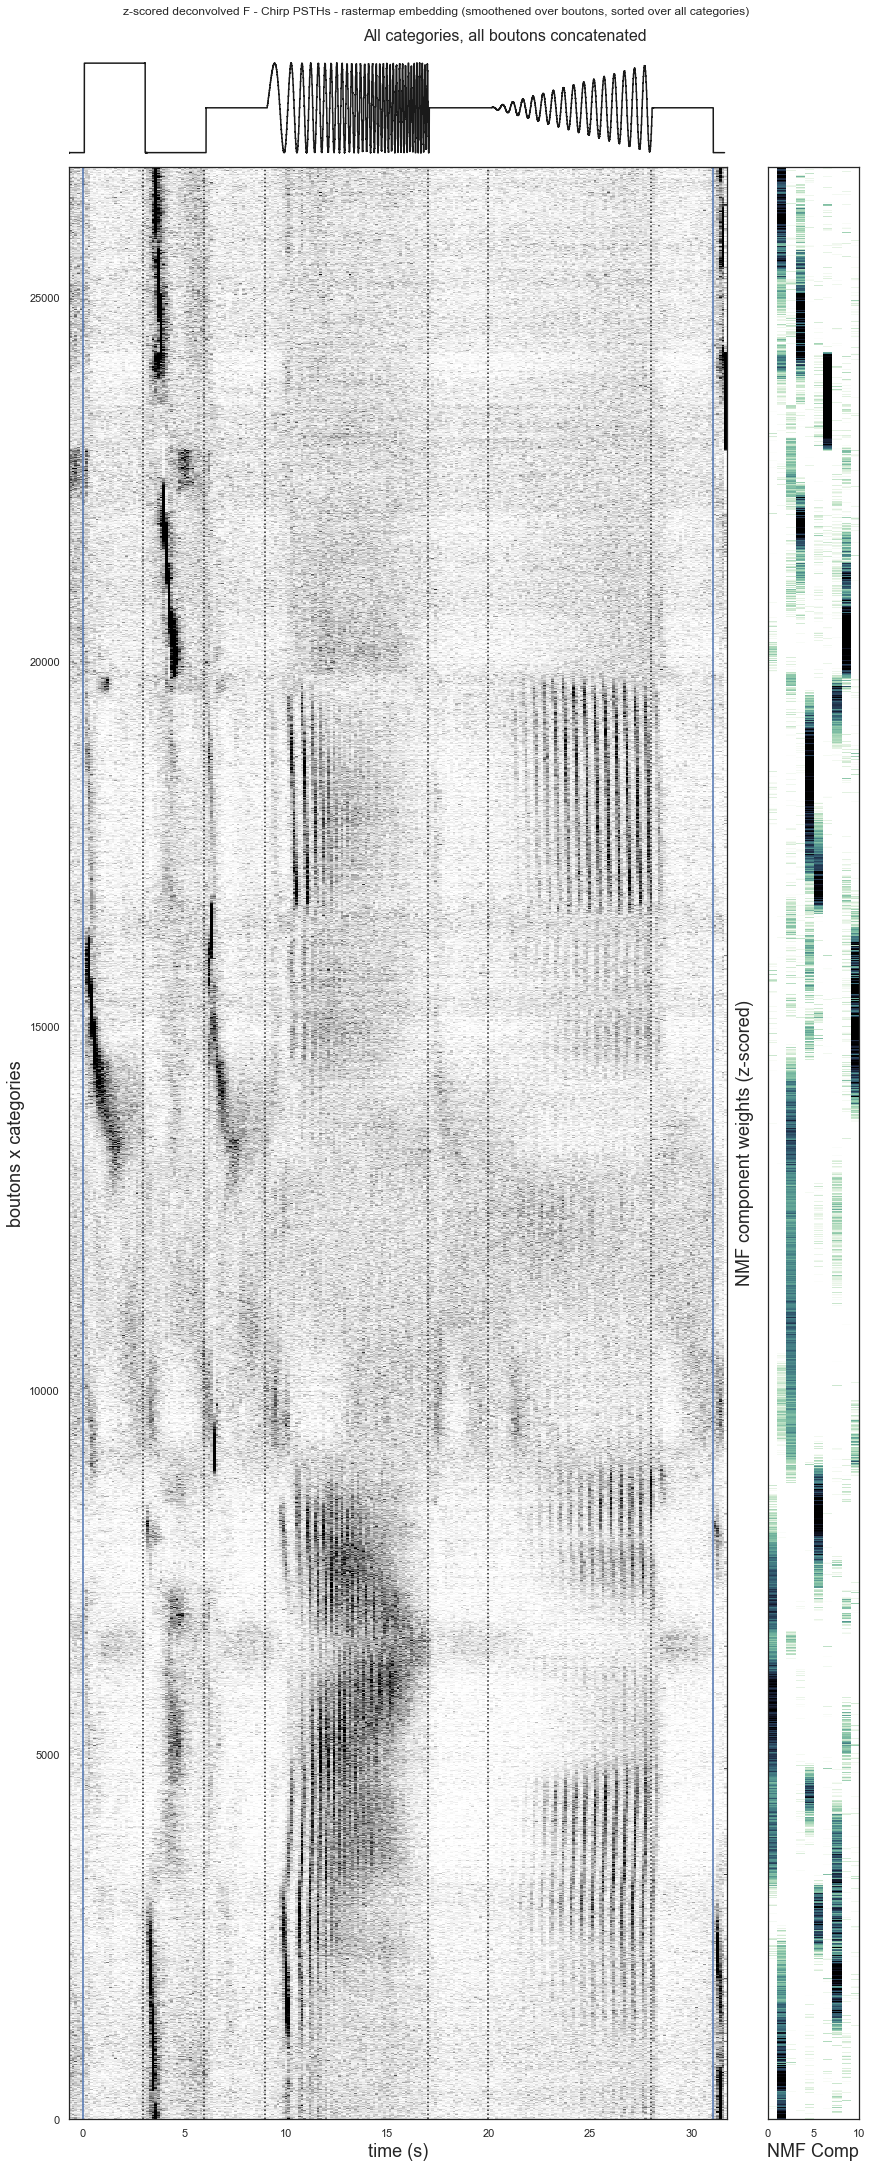

In [43]:
### view neuron sorting
# cmapch = sns.cubehelix_palette(as_cmap=True, reverse=False, rot=-.4) 
cmapch = sns.cubehelix_palette(dark=0, light=1, as_cmap=True, reverse=False, rot=-.4) 
fs = ids[0]['framerate_auxderived'] / level
vmin_glob = 0
vmax_glob = 2.5
lplot = len(Sm_all_vert)

with sns.axes_style('white'):
    xl = [-prestim[0],Sm_all_vert.shape[1]/fs - prestim[0]]
    
    fig11 = plt.figure(figsize=(12,30), constrained_layout=True)
    
    gs1 = fig11.add_gridspec(nrows=12, ncols=5)
    
    fig11.add_subplot(gs1[1:, :-1])      
    fig11_ax=plt.imshow(Sm_all_vert, vmin=vmin_glob,vmax=vmax_glob,aspect='auto',extent=[-prestim[0],Sm_all_vert.shape[1]/fs-prestim[0], 0,Sm_all_vert.shape[0]], cmap = 'gray_r')
    plt.xlabel('time (s)', fontsize=18)    
    plt.ylabel('boutons x categories', fontsize=18)         
    plt.vlines([prestim_frames[0] / fs-prestim[0], maxlength / fs - poststim_frames[0] / fs -prestim[0]],0,lplot-1, 'b')
    plt.vlines([prestim_frames[0] / fs-prestim[0] + flashdur, 
            prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black, 
            prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp,
            prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp + chirp,
            prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp + chirp + ITI_black,
            prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp + chirp + ITI_black + chirp,
           ],0,lplot-1, 'k', 'dotted')
    
    
    fig11.add_subplot(gs1[1:, -1:])  
    fig11_ax2=plt.imshow(Sm_zscored_weights, vmin=vmin_glob,vmax=vmax_glob,aspect='auto', extent=[0,Sm_zscored_weights.shape[1], 0,Sm_all_vert.shape[0]], cmap = cmapch)
    plt.gca().set_yticklabels([])        
    plt.xlabel('NMF Comp', fontsize=18)
    plt.ylabel('NMF component weights (z-scored)', fontsize=18)   
    
    f11_ax4 = fig11.add_subplot(gs1[:1, :-1])    
    plt.plot(aux_time_full, aligned_stimdata_full, 'k')
    f11_ax4.set_xlim(*xl)
    f11_ax4.axis('off')

    plt.text(aux_time_full[-1] / 2 - 2, 5 , 'All categories, all boutons concatenated', fontsize=16)  
          
    plt.suptitle('z-scored deconvolved F - Chirp PSTHs - rastermap embedding (smoothened over boutons, sorted over all categories)')
    
    plt.show()

In [45]:
plt.savefig('all_concat_NMF.pdf', format='pdf')

<Figure size 432x288 with 0 Axes>

In [ ]:
### sort by nmf component weight

# newsort = np.argsort(zscored_weights, axis = 1)
newsort = np.lexsort((zscored_weights[:,0],zscored_weights[:,1],zscored_weights[:,2],zscored_weights[:,3],zscored_weights[:,4],zscored_weights[:,5]))
### sort neurons and smooth across neurons 
smooth = True
timesmooth = True
Sm_zscored_weights = zscored_weights[newsort,:]

if smooth:
    isort = np.argsort(model_all_vert.embedding[:,0])   
    Sm_all_vert  = gaussian_filter1d(all_data.T[newsort,:], np.minimum(3,int(all_data.shape[0]*0.05)), axis=0)
    Sm_zscored_weights = gaussian_filter1d(zscored_weights[newsort,:], np.minimum(3,int(zscored_weights.T.shape[0]*0.5)), axis=0)
#     Sm_all= sp_all.T[isort,:]
else:
    Sm_all_vert  = all_data.T[isort,:]
    Sm_zscored_weights = zscored_weights[newsort,:]

    
if timesmooth:
    sigma = .5
# (optional) smooth in time
    Sm_all_vert = gaussian_filter1d(Sm_all_vert, sigma, axis=1)
    Sm_zscored_weights = gaussian_filter1d(Sm_zscored_weights, sigma, axis=1)




In [ ]:
### view neuron sorting
# cmapch = sns.cubehelix_palette(as_cmap=True, reverse=False, rot=-.4) 
cmapch = sns.cubehelix_palette(dark=0.05, light=.95, as_cmap=True, reverse=False, rot=-.4) 
fs = ids[0]['framerate_auxderived'] / level
vmin_glob = 0
vmax_glob = 2.5
lplot = len(Sm_all_vert)

with sns.axes_style('white'):
    xl = [-prestim[0],Sm_all_vert.shape[1]/fs - prestim[0]]
    
    fig11 = plt.figure(figsize=(12,80), constrained_layout=True)
    
    gs1 = fig11.add_gridspec(nrows=12, ncols=8)
    
    fig11.add_subplot(gs1[1:, :-1])      
    fig11_ax=plt.imshow(Sm_all_vert, vmin=vmin_glob,vmax=vmax_glob,aspect='auto',extent=[-prestim[0],Sm_all_vert.shape[1]/fs-prestim[0], 0,Sm_all_vert.shape[0]], cmap = 'gray_r')
    plt.xlabel('time (s)', fontsize=18)    
    plt.ylabel('boutons x eye-categories', fontsize=18)         
    plt.vlines([prestim_frames[0] / fs-prestim[0], maxlength / fs - poststim_frames[0] / fs -prestim[0]],0,lplot-1, 'b')
      
    fig11.add_subplot(gs1[1:, -1:])  
    fig11_ax2=plt.imshow(Sm_zscored_weights, vmin=vmin_glob,vmax=vmax_glob,aspect='auto', extent=[0,Sm_zscored_weights.shape[1], 0,Sm_all_vert.shape[0]], cmap = cmapch)
    plt.gca().set_yticklabels([])        
    plt.xlabel('NMF Comp', fontsize=18)
    plt.ylabel('NMF weight by component', fontsize=18)      
    
    f11_ax4 = fig11.add_subplot(gs1[:1, :-1])    
    plt.plot(aux_time_full, aligned_stimdata_full, 'k')
    f11_ax4.set_xlim(*xl)
    f11_ax4.axis('off')

    plt.text(aux_time_full[-1] / 2 - 2, 5 , 'All eye-categories concatenated', fontsize=16)  
          
    plt.suptitle('z-scored deconvolved F - Chirp PSTHs - rastermap embedding (smoothened over boutons - all experiments ipsi, contra, bino vert concat)')
    
    plt.show()

In [ ]:
plt.savefig('all_vertcat_NMF.pdf', format='pdf')

### plot with matplotlib

In [ ]:
rows = components
cols = int(np.ceil(components / rows))

fig, axs = plt.subplots(rows,cols, figsize=(15, rows*2), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)

k = 0
for ax, d in zip(axs.ravel(), H):
    ax.plot(time, d)
    ax.set_title('component ' + str(k))
    bottom, top = ax.get_ylim()  # return the current ylim    

    ax.vlines([prestim_frames[0] / fs-prestim[0], maxlength / fs - poststim_frames[0] / fs -prestim[0]],bottom,top, 'k')
    ax.vlines([prestim_frames[0] / fs-prestim[0] + flashdur, 
            prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black, 
            prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp,
            prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp + chirp,
            prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp + chirp + ITI_black,
            prestim_frames[0] / fs-prestim[0] + flashdur + ITI_black + pre_chirp + chirp + ITI_black + chirp,
           ],bottom,top, 'k', 'dotted')    
    k += 1
plt.tight_layout()        
plt.show()

In [72]:
plt.savefig('all_vertcat_NMF_components.pdf', format='pdf')

### plot with seaborn

#### melt panda to long-form / tidy

In [ ]:
melted_comp_df_H = pd.melt(comp_df_H, 
                    id_vars='time', # Variables to keep
                    var_name="Component") # Name of melted variable

melted_comp_df_W = pd.melt(comp_df_W, 
                    id_vars=['cell', 'category'], # Variables to keep
                    var_name="Component") # Name of melted variable
melted_comp_df_W['value'] = melted_comp_df_W['value'].astype(float)
melted_comp_df_W['cell'] = melted_comp_df_W['cell'].astype(float)

In [ ]:
plt.figure(figsize=(4,3))
sns.violinplot(x="Component", y = "value", data = melted_comp_df_W, hue = 'category')
# sns.barplot(x="Component", y = "value", data = melted_comp_df_W[melted_comp_df_W['category'] == 'Ipsi'], hue = 'category')
# sns.barplot(x="Component", y = "value", data = melted_comp_df_W[melted_comp_df_W['category'] == 'Bino'], hue = 'category')
plt.show()

In [ ]:
plt.figure()
sns.lineplot(x = 'Component', y = 'value', data = melted_comp_df_W, hue = 'category')

In [ ]:
sns.relplot(x = 'time', y = 'value', data = melted_comp_df_H, row = 'Component', kind = 'line', hue = 'Component', facet_kws={'sharey': False, 'sharex': True},height=5, aspect=3)
# sns.lineplot(x = 'time', y = 'value', data = melted_df, hue = 'Component', palette = cubehelix)

### generate summed component weights for ipsi contra bino


In [ ]:
comp_df_W.head()

In [ ]:
all_data.shape

In [ ]:
dataframe['cell'][(dataframe['trial'] == 1) & (dataframe['category'] == 'Ipsi')]

In [ ]:
pd.melt(
    id_vars='age',
    var_name='class_renamed',
    value_vars=['First', 'Second', 'Third'],
    value_name='fare'

In [ ]:
rows = components
cols = int(np.ceil(components / rows))

fig, axs = plt.subplots(rows,cols, figsize=(15, rows*2), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)

k = 0

for ax, d in zip(axs.ravel(), H):
    k += 1
    ax.plot(time, d)
#     ax.plot(d)
    ax.set_title('component' + str(k))
    ax.vlines([prestim_frames[0] / fs-prestim[0], maxlength / fs - poststim_frames[0] / fs -prestim[0]],0,4, 'k')
# plt.figure() 
# for x in 
# sns.heatmap(data = comp_df_H.T)
plt.show()